# Simple Linear regression model on Salary data

To get started we will ensure that the required libraries are available:

In [ ]:

%pip install pip --upgrade pip
%pip install numpy
%pip install pandas
%pip install scipy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Next we will import our various libraries. It may be necessary to add others as we run the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

pd.options.mode.copy_on_write = True # This will stop a warning when cleaning our data later in the notebook

## Import our data

We will now import the data from the CSV file. The column headings are in row 0.

In [2]:
df1 = pd.read_csv('ai_job_dataset.csv', header = 0)
df2 = pd.read_csv('ai_job_dataset1.csv', header = 0)
df = pd.concat([df1, df2], ignore_index=True)


Let us see what the data looks like in the data frame.
To get an overall view of the data frame we ill use the various tools pandas gives us: head(), info(), describe() and shape:

In [ ]:
df.head()

In [ ]:
df.info()

## Cleaning and encoding the data

In the data frame above, we have a lot of data that is not relevant to my business objective.
For example, I am not interested in the 'company_name', the 'job_id', 'posting_date' and 'application_deadline' columns amongst others.

In [3]:
df_dropped = df.drop(columns = ['job_id', 'company_name', 'posting_date', 'application_deadline'], axis=1)
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_title               30000 non-null  object 
 1   salary_usd              30000 non-null  int64  
 2   salary_currency         30000 non-null  object 
 3   experience_level        30000 non-null  object 
 4   employment_type         30000 non-null  object 
 5   company_location        30000 non-null  object 
 6   company_size            30000 non-null  object 
 7   employee_residence      30000 non-null  object 
 8   remote_ratio            30000 non-null  int64  
 9   required_skills         30000 non-null  object 
 10  education_required      30000 non-null  object 
 11  years_experience        30000 non-null  int64  
 12  industry                30000 non-null  object 
 13  job_description_length  30000 non-null  int64  
 14  benefits_score          30000 non-null

With the 'salary_currency' column, we have this in USD already and we will keep some location component so we can stick to a like-for like comparison. Since we know where the company will be paying its employees, we can convert the salary to a local figure later if necessary.

I also want to make things more specific to Version 1 and the business objective we are trying to achieve.

I believe that we are more concerned with the business location of the company,(i.e. its 'territory'), so we will keep the 'company_location' column, but since an employee will have to work from one of our offices we do not require 'employee_residence'. Version 1 also deals across industries as a consultancy so the 'industry' column can also be dropped.

This time we will keep the required skills and the remote ratio.

In [4]:
df_reduced = df_dropped.drop(columns = ['salary_currency', 'salary_local', 'employee_residence', 'education_required', 'job_description_length', 'industry'], axis=1)
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         30000 non-null  object 
 1   salary_usd        30000 non-null  int64  
 2   experience_level  30000 non-null  object 
 3   employment_type   30000 non-null  object 
 4   company_location  30000 non-null  object 
 5   company_size      30000 non-null  object 
 6   remote_ratio      30000 non-null  int64  
 7   required_skills   30000 non-null  object 
 8   years_experience  30000 non-null  int64  
 9   benefits_score    30000 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.3+ MB


We have removed some columns that aren't relevant and have kept those that will be of use.
If we compare memory usage and more cleaning will come.

Having removed the irrelevant columns, we can check the data itself. We can look for Null (missing) data and duplicate entries: 

In [5]:
print("Columns    -> missing values:")
df_reduced.isnull().sum()

Columns    -> missing values:


job_title           0
salary_usd          0
experience_level    0
employment_type     0
company_location    0
company_size        0
remote_ratio        0
required_skills     0
years_experience    0
benefits_score      0
dtype: int64

In [6]:
print("Number of duplicate rows:", df_reduced.duplicated().sum())
print(df_reduced.dropna) # sanity check for missing vlues

Number of duplicate rows: 0
<bound method DataFrame.dropna of                       job_title  salary_usd experience_level employment_type  \
0         AI Research Scientist       90376               SE              CT   
1          AI Software Engineer       61895               EN              CT   
2                 AI Specialist      152626               MI              FL   
3                  NLP Engineer       80215               SE              FL   
4                 AI Consultant       54624               EN              PT   
...                         ...         ...              ...             ...   
29995        AI Product Manager       39171               MI              CT   
29996        AI Product Manager       77555               EN              CT   
29997             Data Engineer       28380               EN              FL   
29998             AI Specialist       58764               EN              PT   
29999  Principal Data Scientist       58623               

Looking at this latest output, we can see that there are some job titles which may not fit into our desired outcomes, for example, "robotics engineer" isn't a Version 1 job...
Let's filter on job_title:

Last time we removed the 'job_title' and 'suitable_roles' columns, which was a mistake, and reduced our predicition possibilities. We will now keep the 'suitable_roles' column.

In [7]:
excluded_jobs = ['Robotics', 'Autonomous Systems Engineer']

def filter_jobs(job_title):
    job_lower = job_title.lower()
    if any(ex.lower() in job_lower for ex in excluded_jobs):
        return 'Exclude'
    else:
        return 'Include'
    
df_reduced['suitable_roles'] = df_reduced['job_title'].apply(filter_jobs)
df_included_jobs = df_reduced[ df_reduced['suitable_roles'] != 'Exclude']
df_excluded_jobs = df_reduced[ df_reduced['suitable_roles'] == 'Exclude']

print("Included job_title values:")
print(df_included_jobs['job_title'].unique())

print("Excluded job_title values:")
print(df_excluded_jobs['job_title'].unique())

df_included_jobs = df_included_jobs.drop(columns = ['suitable_roles'])

print(df_included_jobs.info())
print(df_included_jobs.job_title.unique())

Included job_title values:
['AI Research Scientist' 'AI Software Engineer' 'AI Specialist'
 'NLP Engineer' 'AI Consultant' 'AI Architect' 'Principal Data Scientist'
 'Data Analyst' 'AI Product Manager' 'Machine Learning Engineer'
 'Data Engineer' 'Research Scientist' 'ML Ops Engineer' 'Head of AI'
 'Deep Learning Engineer' 'Data Scientist' 'Machine Learning Researcher'
 'Computer Vision Engineer']
Excluded job_title values:
['Autonomous Systems Engineer' 'Robotics Engineer']
<class 'pandas.core.frame.DataFrame'>
Index: 26947 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         26947 non-null  object 
 1   salary_usd        26947 non-null  int64  
 2   experience_level  26947 non-null  object 
 3   employment_type   26947 non-null  object 
 4   company_location  26947 non-null  object 
 5   company_size      26947 non-null  object 
 6   remote_ratio      26947 non-null  i

Looking at the company locations, we can see where they might fit with Version 1 offices, or not. I will simplify this and include Canada as 'North America', EU and scandanavian countries as 'Europe', 'India' and 'United Kingdon' will stay the same and I will include New Zealand and Australia as Australasia. 

In [8]:
office_mappings = {
    'North America': ['United States', 'US', 'USA', 'Canada'],
    'Europe': ['Germany', 'France', 'Spain', 'Austria', 'Italy', 'Netherlands', 'Sweden', 'Norway', 'Denmark', 'Iceland', 'Ireland', 'Switzerland', 'Finland'],
    'UK': ['United Kingdom', 'UK', 'Britain', 'Great Britain'],
    'India': ['India'],
    'Australasia': ['Australia', 'New Zealand'] #, 'Korea', 'S. Korea', 'South Korea', 'Singapore', 'Japan'
}

def select_office(company_location):
    for region, countries in office_mappings.items():
        if company_location.strip().title() in [c.title() for c in countries]:
            return region
    return 'no_office'

df_included_jobs['V1_office'] = df_included_jobs['company_location'].apply(select_office).copy()

df_clean = df_included_jobs[df_included_jobs['V1_office'] != 'no_office'].copy()
offices = list(office_mappings.keys())
df_clean = df_clean.drop(columns = 'company_location')

print(offices)

df_clean.info()

['North America', 'Europe', 'UK', 'India', 'Australasia']
<class 'pandas.core.frame.DataFrame'>
Index: 20220 entries, 1 to 29998
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         20220 non-null  object 
 1   salary_usd        20220 non-null  int64  
 2   experience_level  20220 non-null  object 
 3   employment_type   20220 non-null  object 
 4   company_size      20220 non-null  object 
 5   remote_ratio      20220 non-null  int64  
 6   required_skills   20220 non-null  object 
 7   years_experience  20220 non-null  int64  
 8   benefits_score    20220 non-null  float64
 9   V1_office         20220 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 1.7+ MB


An 'years_experience' integer column will be better than an 'experience_level' and finally 'company_size' and 'employment_type' are no longer needed.

In [9]:
df_final = df_clean[df_clean['employment_type'].isin(['FT', 'FL', 'CL', 'CT'])].copy()

df_final = df_final.drop(columns=['experience_level', 'company_size', 'employment_type'])

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15202 entries, 1 to 29997
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         15202 non-null  object 
 1   salary_usd        15202 non-null  int64  
 2   remote_ratio      15202 non-null  int64  
 3   required_skills   15202 non-null  object 
 4   years_experience  15202 non-null  int64  
 5   benefits_score    15202 non-null  float64
 6   V1_office         15202 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 950.1+ KB


We also want to pull out unique skills from the 'required_skills' column and properly encode them.

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: Clean and prepare skills
skills_lists = df_final['required_skills'].str.split(',').apply(
    lambda x: [skill.strip() for skill in x] if isinstance(x, list) else []
)

# Step 2: Count skill frequencies
all_skills_flat = [skill for skills in skills_lists for skill in skills]
skill_counts = pd.Series(all_skills_flat).value_counts()

# Step 3: Filter to meaningful skills (appear in >1% of jobs)
min_frequency = len(df_final) * 0.01
frequent_skills = skill_counts[skill_counts >= min_frequency].index.tolist()

# Step 4: Filter skills lists to only include frequent skills
filtered_skills_lists = [
    [skill for skill in skills if skill in frequent_skills] 
    for skills in skills_lists
]

# Step 5: Apply MultiLabelBinarizer to filtered skills
mlb = MultiLabelBinarizer()
skills_encoded = mlb.fit_transform(filtered_skills_lists)

# Step 6: Create skill columns
skills_df = pd.DataFrame(
    skills_encoded,
    columns=[f'skill_{skill}' for skill in mlb.classes_],
    index=df_final.index
)

# Step 7: Combine with main DataFrame
df_final = pd.concat([df_final.drop('required_skills', axis=1), skills_df], axis=1)

print(f"Filtered to {len(frequent_skills)} frequent skills")
print(f"Created {skills_df.shape[1]} binary skill columns")

Filtered to 24 frequent skills
Created 24 binary skill columns


Having made sure we have checked for missing or null values (which we would have removed if found), excluded some jobs that aren't in line with Version 1 capabilities, we can now see which columns produce the most unique values:

In [11]:
df_final.nunique().sort_values(ascending = True)

skill_AWS                       2
skill_Azure                     2
skill_Git                       2
skill_GCP                       2
skill_Docker                    2
skill_Deep Learning             2
skill_Data Visualization        2
skill_Computer Vision           2
skill_Hadoop                    2
skill_Java                      2
skill_PyTorch                   2
skill_NLP                       2
skill_Mathematics               2
skill_MLOps                     2
skill_Linux                     2
skill_Kubernetes                2
skill_SQL                       2
skill_Scala                     2
skill_Spark                     2
skill_Statistics                2
skill_Tableau                   2
skill_TensorFlow                2
skill_Python                    2
skill_R                         2
remote_ratio                    3
V1_office                       5
job_title                      18
years_experience               20
benefits_score                 51
salary_usd    

From this, the number of most unique values is obtained from the 'salary_usd' column. We can see what the distribution of the salaries looks like:

<Axes: xlabel='salary_usd', ylabel='Count'>

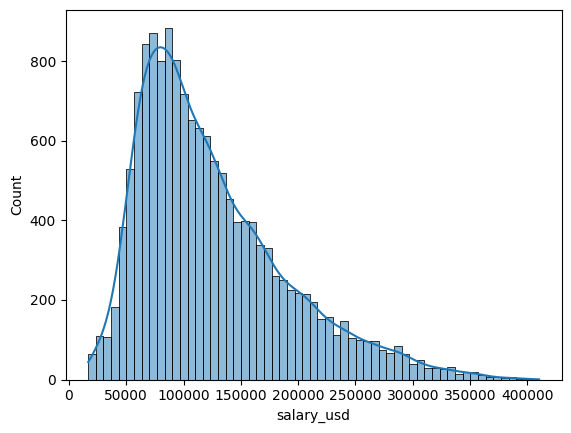

In [12]:
sb.histplot(data=df_final['salary_usd'], kde = True)

This plot suggests we might want to use the log of our salary for a better distribution.
Applying a log transformation to salary (creating log_salary_usd) is a common best practice in regression tasks when the target variable (salary) is highly skewed or spans several orders of magnitude. Here’s why this is advantageous:

1. Reduces Skewness:
Salaries are often right-skewed (many low values, few very high values). Log transformation makes the distribution more symmetric and closer to normal, which is an assumption for many regression models.

2. Stabilizes Variance:
Log transformation reduces heteroscedasticity (when the spread of residuals increases with the value of the target). This helps the model fit better and makes errors more consistent across the range of values.

3. Improves Model Performance:
Linear regression and similar models work best when the relationship between features and target is linear and the errors are normally distributed. Log-transforming the target often makes these assumptions more valid, leading to better predictions and more reliable confidence intervals.

Best Practice:

Use log_salary_usd as your target if the original salary distribution is highly skewed or has outliers.
After prediction, you can convert predictions back to the original scale using np.expm1().
Summary:
Log-transforming salary helps your model by making the data more normal, reducing the impact of outliers, and improving the reliability of your regression results. This is standard practice in salary and income modeling.

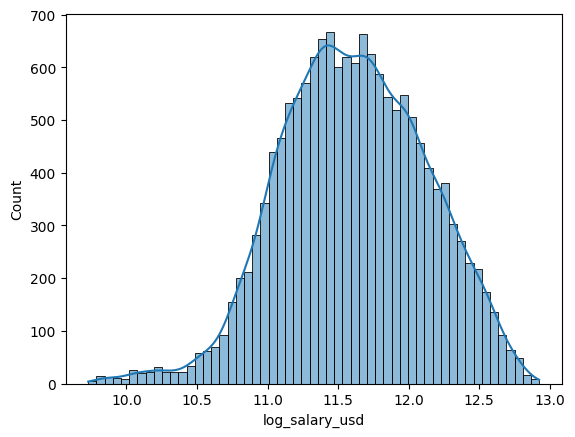

In [13]:
df_final['log_salary_usd'] = np.log1p(df_final['salary_usd'])
sb.histplot(data=df_final['log_salary_usd'], kde = True)
df_final.drop(columns = 'salary_usd', inplace = True)

As we are doing this transformation, we can look at normalizing columns such as the years_experience and the benefits_score:

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_final[['benefits_score', 'years_experience']] = scaler.fit_transform(df_final[['benefits_score', 'years_experience']])

df_final[['benefits_score', 'years_experience']].describe()

,benefits_score,years_experience
count,1.520200e+04,1.520200e+04
mean,6.422087e-16,-7.384933e-17
std,1.000033e+00,1.000033e+00
min,-1.729951e+00,-1.134544e+00
25%,-9.008245e-01,-7.784881e-01
50%,-2.604314e-03,-2.444047e-01
75%,8.956159e-01,6.457343e-01
max,1.724742e+00,2.247984e+00


The remote_ratio is a column with a limited number of values:

In [15]:
# Check the unique values in remote_ratio to understand the data
print("Unique values in remote_ratio:")
print(df_final['remote_ratio'].value_counts().sort_index())

# One-hot encode remote_ratio
remote_dummies = pd.get_dummies(df_final['remote_ratio'], prefix='remote', drop_first=False) # True produces a false result we need to use False as we lose the remote_0 column if we don't
print(f"\nOne-hot encoding created {remote_dummies.shape[1]} binary columns for remote_ratio")
print("Remote ratio columns created:")
print(list(remote_dummies.columns))

# Add the dummy variables to our dataframe
df_final = pd.concat([df_final, remote_dummies], axis=1)
df_final = df_final.drop('remote_ratio', axis=1)

print(f"\nDataframe shape after encoding remote_ratio: {df_final.shape}")

Unique values in remote_ratio:
remote_ratio
0      5071
50     5026
100    5105
Name: count, dtype: int64

One-hot encoding created 3 binary columns for remote_ratio
Remote ratio columns created:
['remote_0', 'remote_50', 'remote_100']

Dataframe shape after encoding remote_ratio: (15202, 32)


While we have reduced the number of columns and reduced the number of rows to suit our needs, we still have data in our final frame that we will need to be converted from an object to a bool or numeric value. This will be done by labelling the columns and using one-hot encoding if necessary.

In [16]:
job_title_dummies = pd.get_dummies(df_final['job_title'], prefix='job', drop_first=True)
print(f"One-hot encoding created {job_title_dummies.shape[1]} binary columns for job titles")

df_final = pd.concat([df_final, job_title_dummies], axis=1)
df_final = df_final.drop('job_title', axis=1)


df_final.info()

One-hot encoding created 17 binary columns for job titles
<class 'pandas.core.frame.DataFrame'>
Index: 15202 entries, 1 to 29997
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   years_experience                 15202 non-null  float64
 1   benefits_score                   15202 non-null  float64
 2   V1_office                        15202 non-null  object 
 3   skill_AWS                        15202 non-null  int64  
 4   skill_Azure                      15202 non-null  int64  
 5   skill_Computer Vision            15202 non-null  int64  
 6   skill_Data Visualization         15202 non-null  int64  
 7   skill_Deep Learning              15202 non-null  int64  
 8   skill_Docker                     15202 non-null  int64  
 9   skill_GCP                        15202 non-null  int64  
 10  skill_Git                        15202 non-null  int64  
 11  skill_Hadoop               

We should do something similar with the V1_office column:

In [17]:
office_dummies = pd.get_dummies(df_final['V1_office'], prefix='Hub', drop_first=False) # True produces a false result we need to use False as we lose the remote_0 column if we don't
print(f"One-hot encoding created {office_dummies.shape[1]} binary columns for job titles")

print(list(office_dummies.columns))

df_final = pd.concat([df_final, office_dummies], axis=1)
df_final = df_final.drop('V1_office', axis=1)


df_final.info()

One-hot encoding created 5 binary columns for job titles
['Hub_Australasia', 'Hub_Europe', 'Hub_India', 'Hub_North America', 'Hub_UK']
<class 'pandas.core.frame.DataFrame'>
Index: 15202 entries, 1 to 29997
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   years_experience                 15202 non-null  float64
 1   benefits_score                   15202 non-null  float64
 2   skill_AWS                        15202 non-null  int64  
 3   skill_Azure                      15202 non-null  int64  
 4   skill_Computer Vision            15202 non-null  int64  
 5   skill_Data Visualization         15202 non-null  int64  
 6   skill_Deep Learning              15202 non-null  int64  
 7   skill_Docker                     15202 non-null  int64  
 8   skill_GCP                        15202 non-null  int64  
 9   skill_Git                        15202 non-null  int64  
 10  skill_Hadoop

Let's have a look at some relationships:

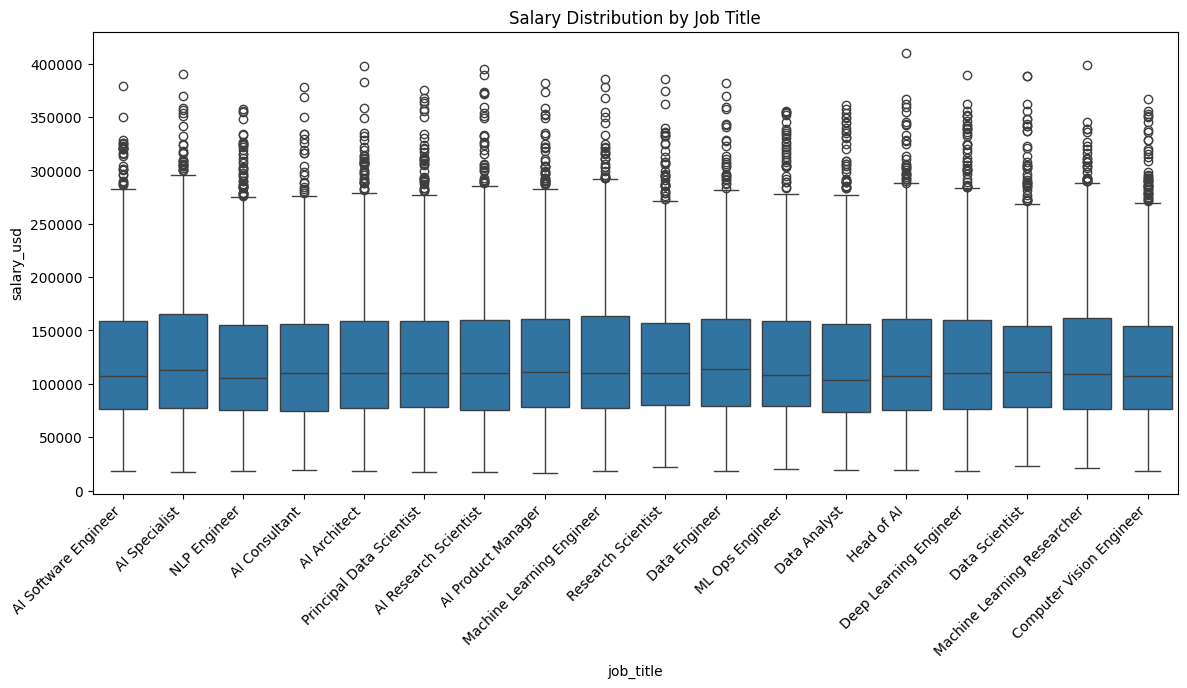

In [18]:
plt.figure(figsize=(14, 6))
sb.boxplot(x='job_title', y='salary_usd', data=df_clean)
plt.xticks(rotation=45, ha='right')
plt.title('Salary Distribution by Job Title')
plt.show()

## Building the simple model

We could now create our 'X' and 'y' datasets, with 'salary_usd' being our prediction target:

We will start with a 80/20 split between training and testing data, and a random_state of 42 (From the hitchhikers guide to the galaxy)

In [19]:
from sklearn.model_selection import train_test_split
y = df_final['log_salary_usd']
X = df_final.drop(columns=['log_salary_usd'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12161, 51)
y_train shape: (12161,)
X_test shape: (3041, 51)
y_test shape: (3041,)


Lets add a correlation map. 1 = perfect correlation, 0 means no correlation:

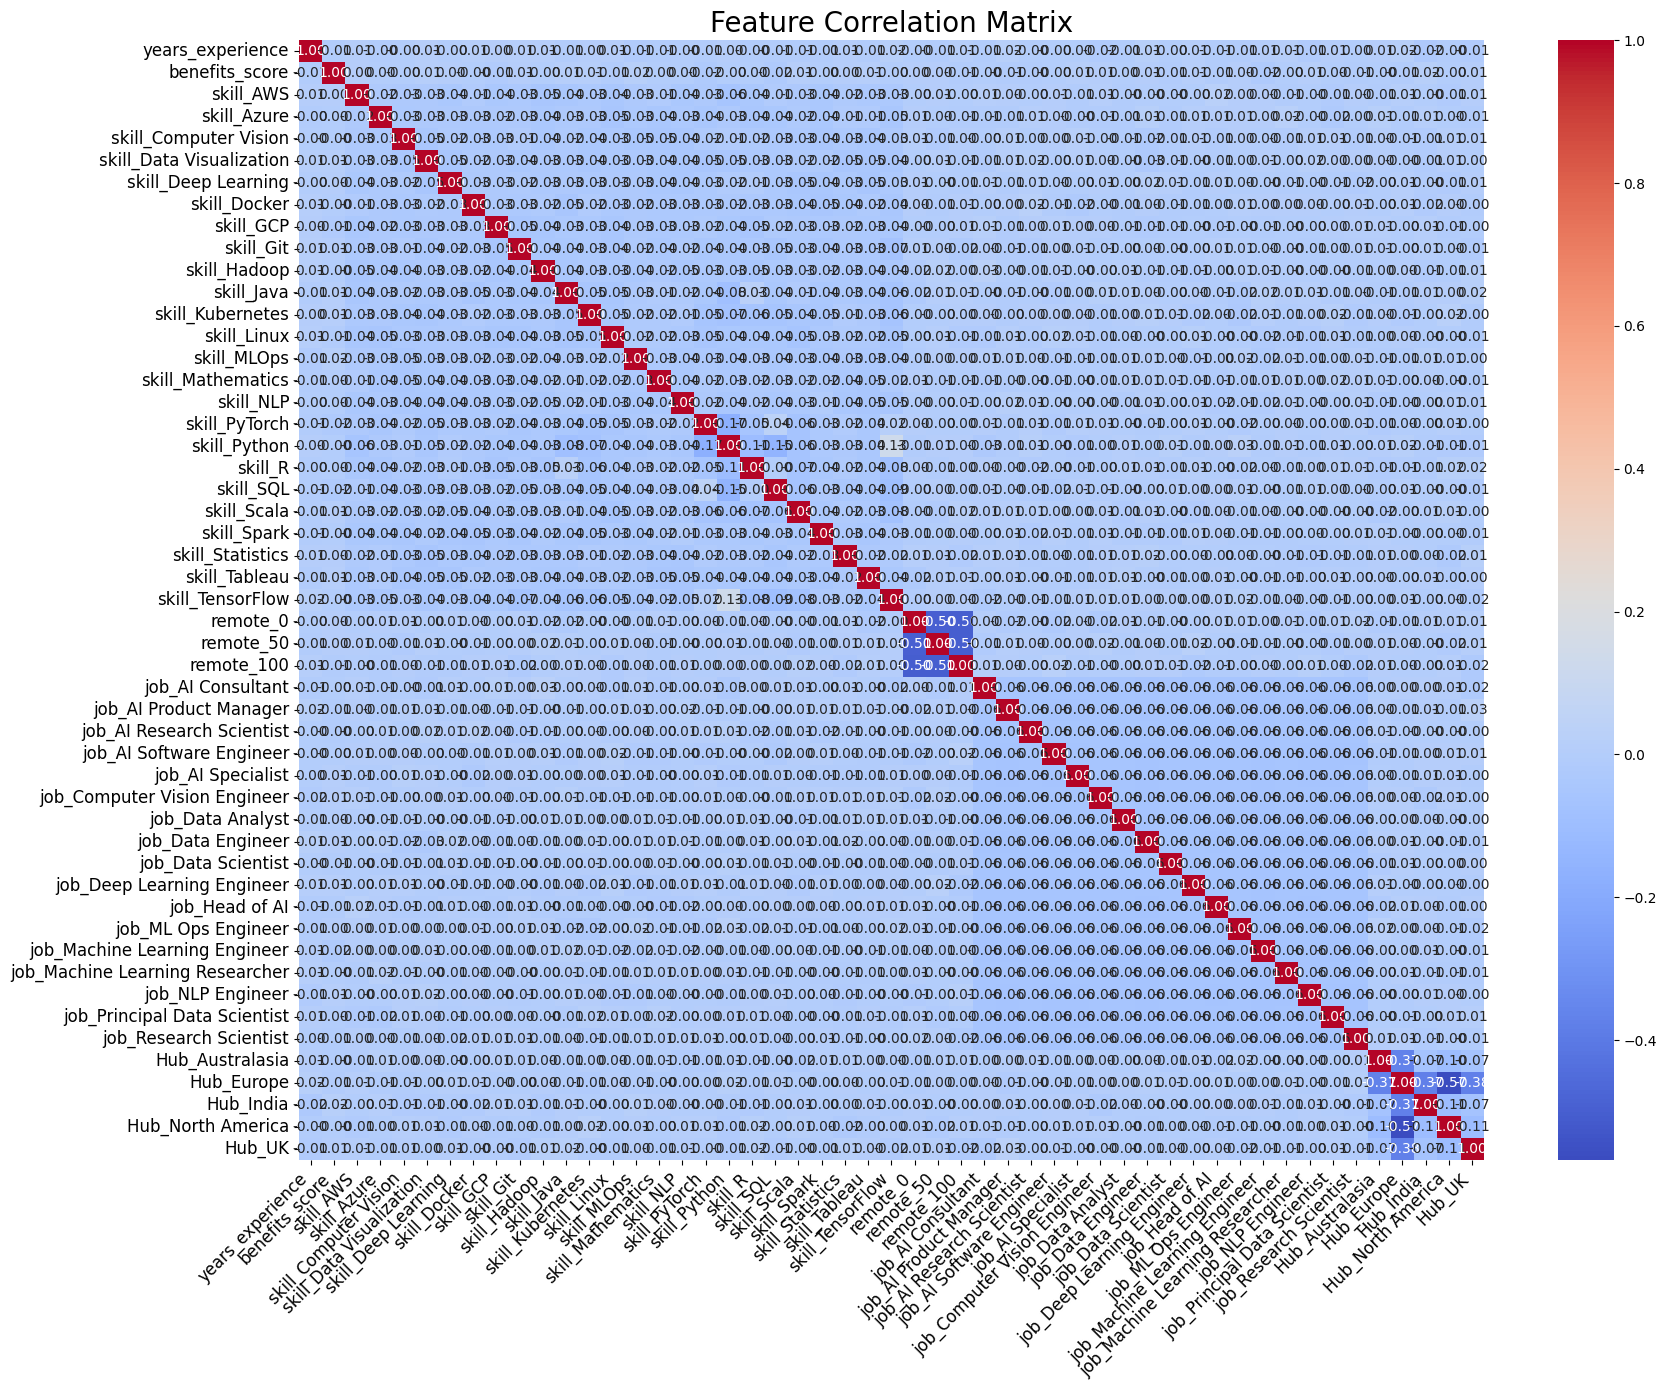

In [20]:
corr_mat = X_train.corr()
plt.figure(figsize=(18, 14))
sb.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix", fontsize=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

To be fair, this isn't telling us a lot. However, this is a third iteration.

And now we will create a simple linear regression model:

In [21]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Model coefficients: [ 3.79804008e-01  8.71081690e-04 -5.01458314e-03  1.49655927e-03
  2.74220031e-03 -1.16762279e-02 -1.21519672e-02  4.84302612e-04
 -2.73444468e-03 -6.31889381e-03  6.44272511e-03 -5.66030721e-03
 -1.70163665e-03  1.02613650e-03 -6.03659471e-03  8.62718185e-03
 -3.50614531e-03  2.44819772e-04  9.12387374e-03 -1.19880073e-02
  1.68286303e-03  1.43444992e-03  4.95068042e-03 -1.09041551e-03
 -4.99922741e-03 -1.09464472e-02  9.51481128e-04 -3.62598755e-03
  2.67450642e-03 -3.13413337e-03  4.23547869e-03  4.11381672e-03
 -2.78410671e-03 -1.13535358e-02  6.49695719e-03 -1.79692495e-02
  2.49423365e-02  8.66838476e-03  6.85066088e-03 -6.99683588e-03
 -7.85891562e-03  7.41262733e-03 -2.73728631e-03  3.20072209e-03
  5.04343705e-03  1.28210772e-02  1.10444544e-01  1.44371698e-01
 -5.75852692e-01  1.59448895e-01  1.61587555e-01]
R2 score training: 0.6717941107779457
R2 score testing: 0.666893437152414
R2 score : 0.666893437152414 , MAE: 0.23667238465190324
count    15202.00000

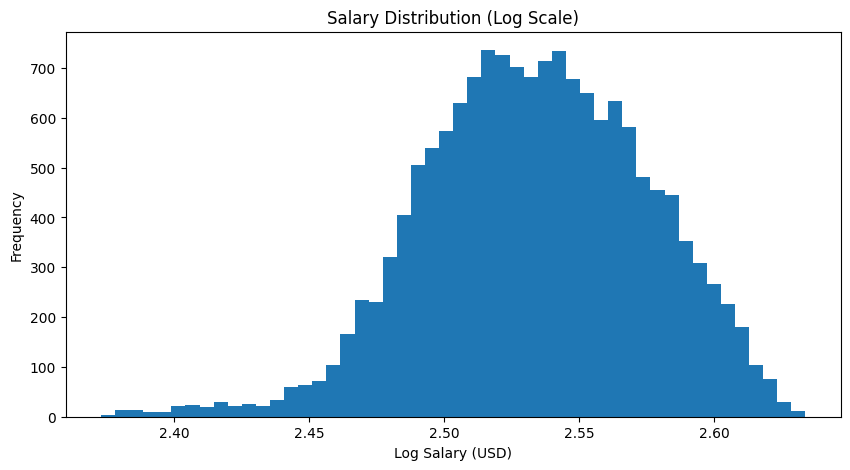

In [22]:
print("Model coefficients:", linear_model.coef_)
print("R2 score training:", linear_model.score(X_train, y_train))
print("R2 score testing:", linear_model.score(X_test, y_test))

y_predict = linear_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'R2 score : {r2_score(y_true=y_test,y_pred=y_predict)} , MAE: {mean_absolute_error(y_test,y_predict)}')

df_final['log_salary_usd'] = np.log1p(df_final['log_salary_usd'])
print(df_final['log_salary_usd'].describe())
df_final['log_salary_usd'].plot(kind='hist', bins=50, figsize=(10, 5), title='Salary Distribution (Log Scale)', xlabel='Log Salary (USD)', ylabel='Frequency')
print("Mean Salary is: ", df_final['log_salary_usd'].mean())

relative_mae = (mean_absolute_error(y_test, y_predict) / y_test.mean())*100
print(f'Relative MAE: {relative_mae:.4f}%')

true_y_predict=np.expm1(y_predict)
true_y_test=np.expm1(y_test)
print(f'True R2 score : {r2_score(y_true=true_y_test,y_pred=true_y_predict)} ,True MAE: {mean_absolute_error(true_y_test,true_y_predict)}')


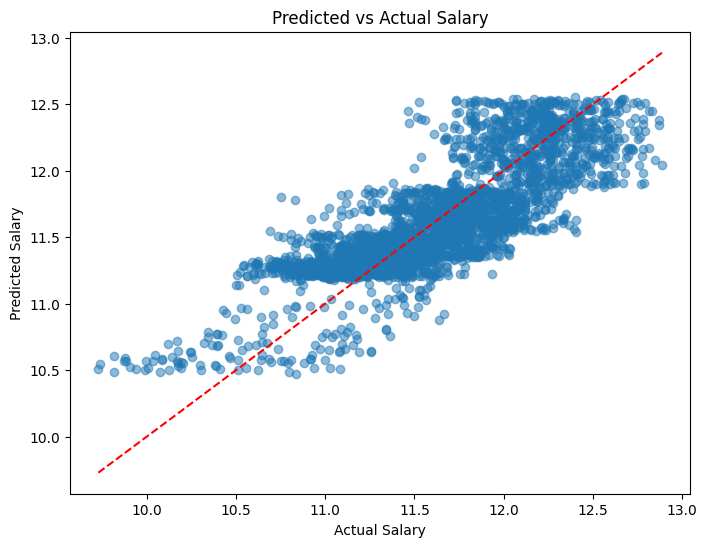

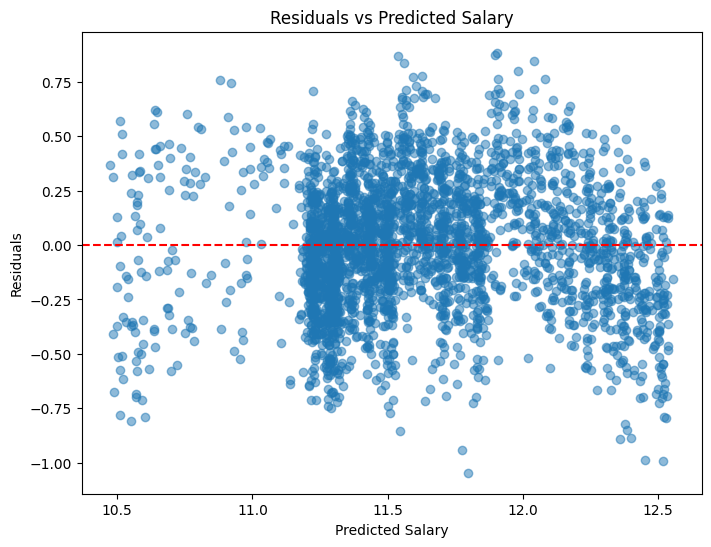

In [23]:
# 1. Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Predicted vs Actual Salary')
plt.show()

# 2. Residuals Plot
residuals = y_test - y_predict
plt.figure(figsize=(8,6))
plt.scatter(y_predict, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Salary')
plt.show()

I am more confident that the model and data have been prepared properly and can produce more accurate results so we will look at some improvements using

## Hyperparameter tuning

We will use gridsearchcv, lasso and ridge regression.

In [24]:
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import Lasso

model = Lasso(random_state = 4, max_iter=20000) # The hyperparameter alpha will be adjusted in the gridsearch
# Define the cross-validation scheme using Repeated K-Fold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # This will create multiple (n_splits * n_repeats) splits for more robust model evaluation

clf = GridSearchCV(model, parameters, cv = cv, n_jobs=1, scoring = 'neg_root_mean_squared_error',verbose=3)

# Fit the model on the training data
clf.fit(X=X_train, y=y_train)
lasso_model = clf.best_estimator_  # Retrieve the best estimator (best alpha value found by grid search)

print('The best alpha value is {}'.format(clf.best_params_['alpha']))

# Use the best Lasso model to make predictions on the test set
y_pred = lasso_model.predict(X_test)

Fitting 30 folds for each of 8 candidates, totalling 240 fits
[CV 1/30] END ....................alpha=0.0001;, score=-0.292 total time=   1.1s
[CV 2/30] END ....................alpha=0.0001;, score=-0.293 total time=   1.3s
[CV 3/30] END ....................alpha=0.0001;, score=-0.301 total time=   1.2s
[CV 4/30] END ....................alpha=0.0001;, score=-0.290 total time=   1.6s
[CV 5/30] END ....................alpha=0.0001;, score=-0.305 total time=   1.5s
[CV 6/30] END ....................alpha=0.0001;, score=-0.304 total time=   1.4s
[CV 7/30] END ....................alpha=0.0001;, score=-0.297 total time=   1.6s
[CV 8/30] END ....................alpha=0.0001;, score=-0.302 total time=   1.6s
[CV 9/30] END ....................alpha=0.0001;, score=-0.290 total time=   1.5s
[CV 10/30] END ...................alpha=0.0001;, score=-0.294 total time=   1.4s
[CV 11/30] END ...................alpha=0.0001;, score=-0.298 total time=   1.6s
[CV 12/30] END ...................alpha=0.0001;

Now we will try ridge regression:

In [25]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=4, max_iter=20000)
grid_ridge = GridSearchCV(ridge, parameters, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)
grid_ridge.fit(X_train, y_train)

ridge_best = grid_ridge.best_estimator_
print("Best Ridge alpha:", grid_ridge.best_params_['alpha'])


Fitting 30 folds for each of 8 candidates, totalling 240 fits
Best Ridge alpha: 10


Compare:


In [26]:
y_pred_lr = linear_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_best.predict(X_test)

# Create a results summary
def regression_report(y_true, y_pred, name="Model"):
    print(f"\n{name} Results:")
    print("  MAE:  ", mean_absolute_error(y_true, y_pred))
    print("  RMSE: ", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("  R2:   ", r2_score(y_true, y_pred))

regression_report(y_test, y_pred_lr, "LinearRegression")
regression_report(y_test, y_pred_lasso, "Lasso")
regression_report(y_test, y_pred_ridge, "Ridge")


LinearRegression Results:
  MAE:   0.23667238465190324
  RMSE:  0.2963504136654856
  R2:    0.666893437152414

Lasso Results:
  MAE:   0.2367905789743656
  RMSE:  0.29624579749856444
  R2:    0.6671285789250001

Ridge Results:
  MAE:   0.236663426831127
  RMSE:  0.2963571550233966
  R2:    0.6668782820117402


These results mean that the cleaning, encoding and normalization are making the data very well behaved. It will probably be time to use a model like XGBoost in iteration 4

In [27]:
df_final['log_salary_usd'] = y
df_final.to_csv('ai_job_dataset_cleaned.csv', index=False)

Lets look at some predicions:

In [28]:
feature_cols = [c for c in df.columns if c not in ['log_salary_usd']]
X_train_cols = X_train.columns

# Build a new row as a dictionary
example = {col: 0 for col in X_train_cols}  # Set everything to 0 by default

# Set values for this scenario
example['job_Data Scientist'] = 1
example['Hub_UK'] = 1    # if you have one-hot encoded 'location'
example['remote_100'] = True     # or whatever is appropriate

# Optionally set some skills ON (e.g. Python, Machine Learning, etc.)
#example['skills_Python'] = 1
#example['skills_Machine Learning'] = 1

# Turn into DataFrame for prediction
example_df = pd.DataFrame([example])

# Make prediction (log scale)
log_salary_pred = linear_model.predict(example_df)[0]
# Convert back to salary
lin_salary_pred = np.exp(log_salary_pred)

print(f"Linear predicted salary for Data Scientist in Hub_UK: ${lin_salary_pred:,.0f}")

log_salary_pred_lasso = lasso_model.predict(example_df)[0]
# Convert back to salary
las_salary_pred = np.exp(log_salary_pred_lasso)

print(f"Lasso predicted salary for Data Scientist in Hub_UK: ${las_salary_pred:,.0f}")

log_salary_pred_ridge = ridge_best.predict(example_df)[0]
# Convert back to salary
rid_salary_pred = np.exp(log_salary_pred_ridge)

print(f"Lasso predicted salary for Data Scientist in Hub_UK: ${rid_salary_pred:,.0f}")

Linear predicted salary for Data Scientist in Hub_UK: $119,236
Lasso predicted salary for Data Scientist in Hub_UK: $115,532
Lasso predicted salary for Data Scientist in Hub_UK: $118,940


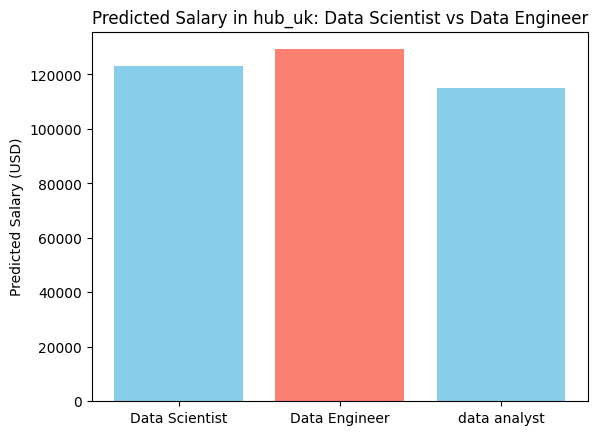

In [29]:
hub_uk_rows = df_final[df_final['Hub_UK'] == 1]

# 2. Select Data Scientist and Data Engineer rows
job_titles = ['job_Data Scientist', 'job_Data Engineer', 'job_Data Analyst']
title_labels = ['Data Scientist', 'Data Engineer', 'data analyst']
mean_salaries = []

for jt, label in zip(job_titles, title_labels):
    # Only rows where this job_title is ON (1)
    subset = hub_uk_rows[hub_uk_rows[jt] == 1]
    if subset.empty:
        mean_salaries.append(np.nan)
    else:
        # Prepare features: use the same columns as X_train
        X = subset[X_train.columns]
        log_preds = linear_model.predict(X)
        preds = np.exp(log_preds)
        mean_salaries.append(np.mean(preds))

# 3. Plot
plt.bar(title_labels, mean_salaries, color=['skyblue', 'salmon'])
plt.ylabel('Predicted Salary (USD)')
plt.title('Predicted Salary in hub_uk: Data Scientist vs Data Engineer')
plt.show()

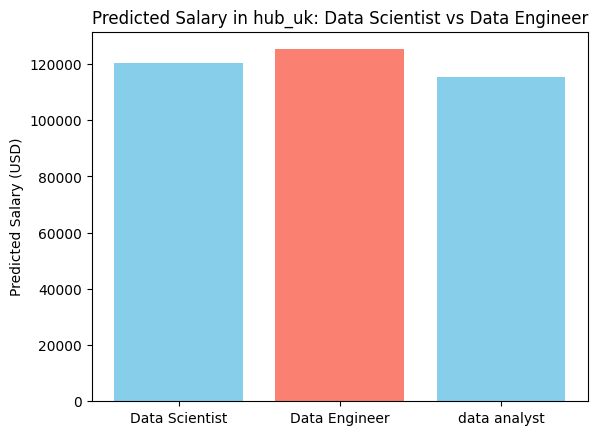

In [30]:
hub_uk_rows = df_final[df_final['Hub_UK'] == 1]

# 2. Select Data Scientist and Data Engineer rows
job_titles = ['job_Data Scientist', 'job_Data Engineer', 'job_Data Analyst']
title_labels = ['Data Scientist', 'Data Engineer', 'data analyst']
mean_salaries = []

for jt, label in zip(job_titles, title_labels):
    # Only rows where this job_title is ON (1)
    subset = hub_uk_rows[hub_uk_rows[jt] == 1]
    if subset.empty:
        mean_salaries.append(np.nan)
    else:
        # Prepare features: use the same columns as X_train
        X = subset[X_train.columns]
        log_preds = lasso_model.predict(X)
        preds = np.exp(log_preds)
        mean_salaries.append(np.mean(preds))

# 3. Plot
plt.bar(title_labels, mean_salaries, color=['skyblue', 'salmon'])
plt.ylabel('Predicted Salary (USD)')
plt.title('Predicted Salary in hub_uk: Data Scientist vs Data Engineer')
plt.show()

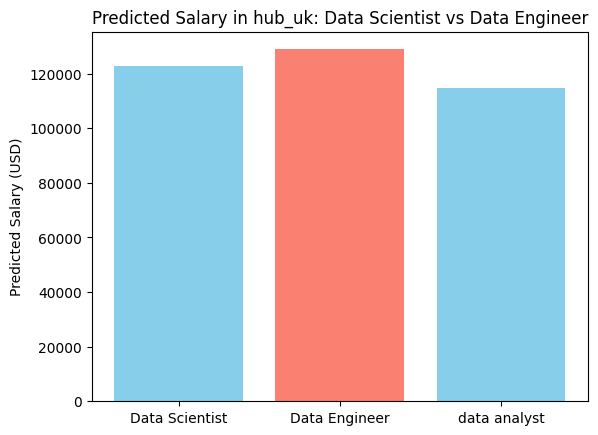

In [31]:
hub_uk_rows = df_final[df_final['Hub_UK'] == 1]

# 2. Select Data Scientist and Data Engineer rows
job_titles = ['job_Data Scientist', 'job_Data Engineer', 'job_Data Analyst']
title_labels = ['Data Scientist', 'Data Engineer', 'data analyst']
mean_salaries = []

for jt, label in zip(job_titles, title_labels):
    # Only rows where this job_title is ON (1)
    subset = hub_uk_rows[hub_uk_rows[jt] == 1]
    if subset.empty:
        mean_salaries.append(np.nan)
    else:
        # Prepare features: use the same columns as X_train
        X = subset[X_train.columns]
        log_preds = ridge_best.predict(X)
        preds = np.exp(log_preds)
        mean_salaries.append(np.mean(preds))

# 3. Plot
plt.bar(title_labels, mean_salaries, color=['skyblue', 'salmon'])
plt.ylabel('Predicted Salary (USD)')
plt.title('Predicted Salary in hub_uk: Data Scientist vs Data Engineer')
plt.show()

With only salary taken into account, where would the most cost effective office to hire a Data Scientist?

[{'Hub': 'Australasia', 'AvgPredSalary': np.float64(133762.37409078036)}, {'Hub': 'Europe', 'AvgPredSalary': np.float64(123566.19670824704)}, {'Hub': 'India', 'AvgPredSalary': np.float64(61561.14633921577)}, {'Hub': 'North America', 'AvgPredSalary': np.float64(123571.53476034559)}, {'Hub': 'UK', 'AvgPredSalary': np.float64(122960.56541209183)}]


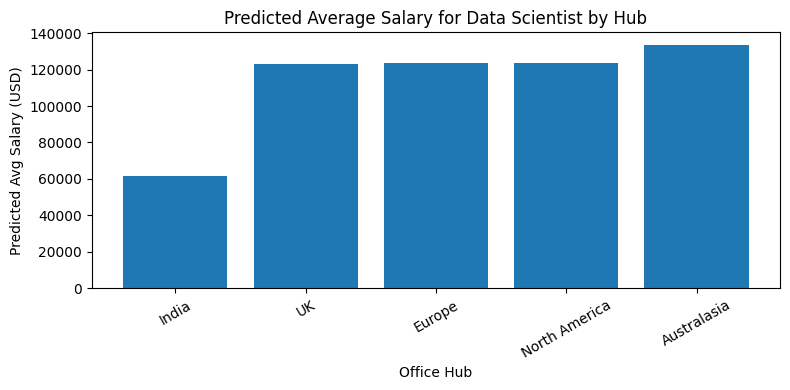

Best value office hub for Data Scientist: India ($61,561 avg predicted salary)


In [32]:
hub_cols = [col for col in df_final.columns if col.startswith("Hub_")]

feature_cols = [c for c in df_final.columns if c not in ['log_salary_usd']]

results = []

for hub in hub_cols:
    # Find rows that are both this hub and Data Scientist
    mask = (df_final[hub] == 1) & (df_final['job_Data Scientist'] == 1)
    if mask.sum() == 0:
        continue  # Skip if no matching rows

    X = df_final.loc[mask, feature_cols]
    log_preds = linear_model.predict(X)
    salaries = np.exp(log_preds)
    avg_salary = salaries.mean()
    results.append({'Hub': hub.replace("Hub_", ""), 'AvgPredSalary': avg_salary})

print(results)

if results:
    # Convert results to DataFrame and sort by salary
    results_df = pd.DataFrame(results).sort_values('AvgPredSalary')

    plt.figure(figsize=(8,4))
    plt.bar(results_df['Hub'], results_df['AvgPredSalary'])
    plt.ylabel('Predicted Avg Salary (USD)')
    plt.xlabel('Office Hub')
    plt.title('Predicted Average Salary for Data Scientist by Hub')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Print the "best value" (lowest avg salary) location
    best_value = results_df.iloc[0]
    print(f"Best value office hub for Data Scientist: {best_value['Hub']} (${best_value['AvgPredSalary']:,.0f} avg predicted salary)")
else:
    print("No Data Scientist roles found in any office hubs.")